### Collecting data from Excel after projecting onto Fundamental region
Here we will not do any adjustment in the data before performing the GPR.

Now let us import the data in the adjusted_data sheet into a variable df using pandas.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'file.xlsx' with the path to your Excel file
file_path = '/Users/Jayee/Downloads/Nanoindentation data-selected/Berkovich Nanoindentation Strain rates of E-2 E-1 and E0 per second/Strain rate of E0 ps.xlsx'

# Read Excel file into a DataFrame, handling any blank spaces as NaN
# Use the 'usecols' parameter to specify the range of columns to read
df = pd.read_excel(file_path,sheet_name = "E0_test no_euler angles_EBSD" , na_values=' ', usecols='A:E')  # Assuming columns A to Z contain data

# Drop rows with any missing values
df.dropna(inplace=True)

# Print the DataFrame
print(df)


     Test #  φ1 (°)  Φ (°)  φ2 (°)   H (GPa)
0       1.0  308.71  43.48   39.96  5.601675
1       2.0  311.62  43.36   36.85  5.574661
2       9.0  339.34  14.99   47.72  5.620957
3      33.0  179.30  45.26   40.19  4.900000
4      34.0  180.99  44.69   39.31  5.500000
..      ...     ...    ...     ...       ...
92     10.0  356.01  40.63    5.75  6.426607
93     18.0  140.11  43.58   31.79  5.671592
94     47.0  290.15  34.62    0.91  6.772578
107    33.0  326.36  40.71   53.90  6.640766
108    47.0  141.65  14.07   45.84  8.185540

[70 rows x 5 columns]


### Step2: saving our data as an array.
Lets save all our data as an array called data.

In [71]:
import numpy as np
data = df.values
data = np.array(data)
n_data = data.shape[0]
print(f"n_data = ", n_data)

n_data =  70


### Step3: Segregating training and test data.
We have n_data = 79. Now out of 79 let us train 69 data points using GPR and the rest 10 let us put it as test data. But we will first select the data at random.

In [72]:
import random
random.seed(0)

n_test = 10
n_train = n_data-n_test

random_numbers = random.sample(range(n_data), n_data)
data_train = data[random_numbers[0:n_train],1:]
data_test = data[random_numbers[n_train:],1:]

### Step4: Segregating the X and Y data
We have a 2d array with the first 3 columns representing the euler angles and the 4th column representing the hardness. so lets seperate them as x and y respectively


In [73]:
x_train = data_train[:,0:-1]
y_train = data_train[:,-1]

x_test = data_test[:,0:-1]
y_test = data_test[:,-1]

### Step4: Scaling the x_train and x_test


In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Step5: Perfoming GPR

In [75]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import WhiteKernel,RBF

ls = [1,1,1]
lsb = [1e-2,1e7]
kernel = 1* RBF(length_scale = ls, length_scale_bounds=lsb)+ WhiteKernel(
    noise_level=2, noise_level_bounds=(1e-2, 1e2))

gp = GPR(kernel=kernel,n_restarts_optimizer=10,random_state=1)
gp.max_iter_predict = 100

gp.fit(x_train_scaled,y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=10, random_state=1)

In [76]:
gp.kernel_

5.25**2 * RBF(length_scale=[4.28e+04, 4.18e+06, 18.2]) + WhiteKernel(noise_level=0.449)

In [77]:
y_mean_pred,y_std_pred = gp.predict(x_test_scaled,return_std=True)

In [78]:
_ = [min(y_mean_pred),max(y_mean_pred), min(y_test),max(y_test),min(y_train),max(y_train)]
temp1 = [min(_),max(_)]
temp2 = [min(_),max(_)]

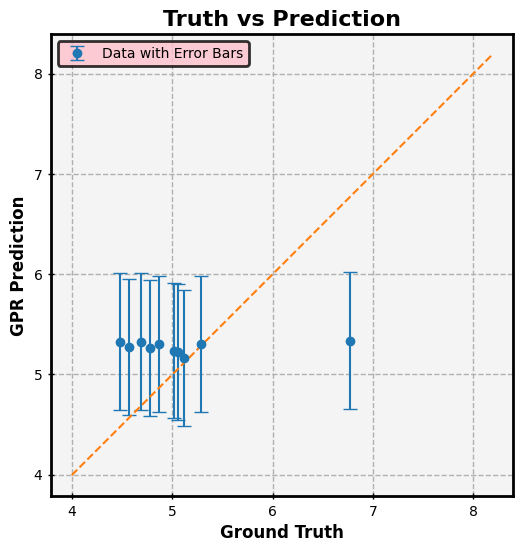

In [79]:
#plotting the curves
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.set_title("Truth vs Prediction",fontweight="bold", fontsize=16)

axs.set_xlabel("Ground Truth", fontweight="bold",fontsize=12)
axs.set_ylabel("GPR Prediction",fontweight="bold",fontsize=12)
axs.errorbar(y_test, y_mean_pred, yerr=y_std_pred, fmt='o', capsize=5, label='Data with Error Bars')
axs.plot(temp1,temp1,"--")



axs.grid("on",linestyle="--",linewidth=1)
axs.set_aspect("equal")
#axs[(axs_num)].axis("equal")
axs.set_facecolor("#f4f4f4")
legend = axs.legend(loc="best",fontsize=10)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor("black")
legend.get_frame().set_facecolor("pink")
spines_dict = ["top","bottom","left","right"]
for spine_value in spines_dict:
    axs.spines[spine_value].set_linewidth(2)
axs.tick_params(axis="both",direction="inout", length=5, width=1,labelsize=10)
plt.savefig("raw_e0.pdf")
plt.show()
